### Autores: **Angel David Piñeros Sierra**, **Camilo Andrés Roncancio Toca**, **Kelly Johana Solano Calderón**



---



## **Tarea 3 - Semantic Segmentation**





**Sobre las redes convolucionales (CNN):**

Las redes convolucionales son ampliamente utilizadas para el procesamiento de imágenes, teniendo en cuenta sus propiedades y dimensiones. Este tipo de redes esta conformado por capas convolucionales totalmente conectadas que procesan regiones locales de las imágenes de forma independiente, utilizando parámetros que se comparten a lo largo de toda la imagen.

Se tienen en cuenta las siguientes propiedades y procesos:

*   La representación de una imagen se mantiene, así se le hayan aplicado transformaciones (ej: traslación).
*   El proceso de convolución se refiere a la transformación de un vector de entrada $x$ a un vector de salida $z$, donde cada elemento $z_i$ es la suman ponderada de las entradas cercanas a la posición $i$. Los mismos valores de los pesos se utilizan en cada posición del recorrigo, llamandose



**Sobre las redes residuales**


**La arquitectura U-Net**




### **Tratamiento de datos**


In [1]:
'''
Importación de datos
'''

!pip install gdown
id_gdrive = "1gCpZHm9dS2ELSIpS3mJb2RL6PCBk7muF"
nombre_archivo = "coffee_leaves.7z"
!gdown --id $id_gdrive --output $nombre_archivo

/home/angel/Bureau/Tarea 3 IA/.venv/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1gCpZHm9dS2ELSIpS3mJb2RL6PCBk7muF
To: /home/angel/Bureau/Tarea 3 IA/coffee_leaves.7z
100%|██████████████████████████████████████| 58.7M/58.7M [00:09<00:00, 6.12MB/s]


In [2]:
%pip install gdown py7zr pillow torch torchvision matplotlib pandas


Note: you may need to restart the kernel to use updated packages.


In [3]:
import py7zr
import os

def descomprimir_archivo(archivo):
    if os.path.exists(archivo[:-3]):
        return
    with py7zr.SevenZipFile(archivo, mode='r') as z:
         z.extractall(path=archivo[:-3])

descomprimir_archivo('coffee_leaves.7z')

In [4]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
import torch.nn as nn
import torch.nn.functional as F

In [5]:

# Normalización y estandarización de las imágenes de ENTRADA usando estadísticas del propio dataset
# 1) Reescalamos todas las imágenes a un tamaño fijo (potencia de 2)
# 2) ToTensor() normaliza los píxeles de [0, 255] a [0, 1]
# 3) Calculamos media y desviación estándar por canal SOBRE esas imágenes normalizadas
# 4) Usamos esos valores en transforms.Normalize para estandarizar: (x - mean) / std

import numpy as np
import matplotlib.pyplot as plt

train_imgs_dir = os.path.join("coffee_leaves", "coffee_leaves", "train", "imgs")
img_filenames = [f for f in os.listdir(train_imgs_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

# Tamaño objetivo (potencia de 2) para U-Net
TARGET_SIZE = (256, 256)
resize_transform = transforms.Resize(TARGET_SIZE)
mask_resize_transform = transforms.Resize(TARGET_SIZE, interpolation=InterpolationMode.NEAREST)

means = []
stds = []

for fname in img_filenames:
    img_path = os.path.join(train_imgs_dir, fname)
    img = Image.open(img_path).convert("RGB")
    # 1) Reescalamiento de la imagen
    img_resized = resize_transform(img)
    # 2) Normalización: [0, 255] -> [0, 1]
    img_tensor = transforms.ToTensor()(img_resized)
    # media y desviación estándar POR CANAL
    means.append(img_tensor.mean(dim=(1, 2)))
    stds.append(img_tensor.std(dim=(1, 2)))

means = torch.stack(means, dim=0)
stds = torch.stack(stds, dim=0)

# 3) Estadísticos finales del dataset (promedio sobre todas las imágenes)
IMG_MEAN = means.mean(dim=0)
IMG_STD = stds.mean(dim=0)

print("Media por canal (dataset, reescalado a {}x{}):".format(TARGET_SIZE[0], TARGET_SIZE[1]), IMG_MEAN)
print("Desviación estándar por canal (dataset, reescalado a {}x{}):".format(TARGET_SIZE[0], TARGET_SIZE[1]), IMG_STD)




Media por canal (dataset, reescalado a 256x256): tensor([0.6598, 0.6619, 0.5549])
Desviación estándar por canal (dataset, reescalado a 256x256): tensor([0.2301, 0.1921, 0.3116])


In [6]:

# Utilidades de aumento de datos (para imagen y máscara)
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.05)
blur_transform = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))
normalize_transform = transforms.Normalize(mean=IMG_MEAN.tolist(), std=IMG_STD.tolist())
NOISE_STD = 0.01

def add_gaussian_noise(tensor, std=NOISE_STD):
    """Añade ruido gaussiano suave sobre tensores ya normalizados a [0, 1]."""
    if std <= 0:
        return tensor
    noisy_tensor = tensor + std * torch.randn_like(tensor)
    return torch.clamp(noisy_tensor, 0.0, 1.0)

def apply_geometric_augmentations(img, mask):
    """Aplicar rotaciones suaves, flips verticales y zooms ligeros a imagen y máscara."""
    angle = random.uniform(-15.0, 15.0)
    img = TF.rotate(img, angle, interpolation=InterpolationMode.BILINEAR, fill=0)
    mask = TF.rotate(mask, angle, interpolation=InterpolationMode.NEAREST, fill=0)

    flipped = random.random() < 0.5
    if flipped:
        img = TF.vflip(img)
        mask = TF.vflip(mask)

    max_dx = 0.02 * TARGET_SIZE[1]
    max_dy = 0.02 * TARGET_SIZE[0]
    translate = (
        random.uniform(-max_dx, max_dx),
        random.uniform(-max_dy, max_dy),
    )
    scale = random.uniform(0.9, 1.05)

    img = TF.affine(
        img,
        angle=0.0,
        translate=translate,
        scale=scale,
        shear=(0.0, 0.0),
        interpolation=InterpolationMode.BILINEAR,
        fill=0,
    )
    mask = TF.affine(
        mask,
        angle=0.0,
        translate=translate,
        scale=scale,
        shear=(0.0, 0.0),
        interpolation=InterpolationMode.NEAREST,
        fill=0,
    )

    metadata = {
        "rotation_deg": angle,
        "vertical_flip": flipped,
        "translate_px": translate,
        "scale_factor": scale,
    }
    return img, mask, metadata

COLOR_TO_CLASS = {
    (0, 0, 0): 0,      # fondo
    (0, 176, 0): 1,    # hoja sana
    (255, 0, 0): 2,    # mancha / enfermedad
}

def mask_to_tensor(mask):
    """Convierte la máscara RGB original en etiquetas discretas por píxel."""
    mask_rgb = np.array(mask.convert("RGB"))
    class_mask = np.zeros(mask_rgb.shape[:2], dtype=np.uint8)
    for color, cls in COLOR_TO_CLASS.items():
        matches = np.all(mask_rgb == color, axis=-1)
        class_mask[matches] = cls
    return torch.from_numpy(class_mask).long()

def preprocess_training_sample(img, mask, return_metadata=False):
    """Pipeline de entrenamiento: reescala, aplica geometría y variaciones fotométricas."""
    metadata = {}
    img = resize_transform(img)
    mask = mask_resize_transform(mask)

    img, mask, geom_metadata = apply_geometric_augmentations(img, mask)
    metadata.update(geom_metadata)

    img = color_jitter(img)
    metadata["color_jitter"] = True

    blur_applied = random.random() < 0.3
    metadata["blur_applied"] = blur_applied
    if blur_applied:
        img = blur_transform(img)

    img = transforms.ToTensor()(img)
    img = add_gaussian_noise(img, std=NOISE_STD)
    metadata["noise_std"] = NOISE_STD
    img = normalize_transform(img)

    mask = mask_to_tensor(mask)
    if return_metadata:
        return img, mask, metadata
    return img, mask

def preprocess_validation_sample(img, mask):
    """Transformaciones determinísticas para validación/test."""
    img = resize_transform(img)
    mask = mask_resize_transform(mask)

    img = transforms.ToTensor()(img)
    img = normalize_transform(img)
    mask = mask_to_tensor(mask)
    return img, mask



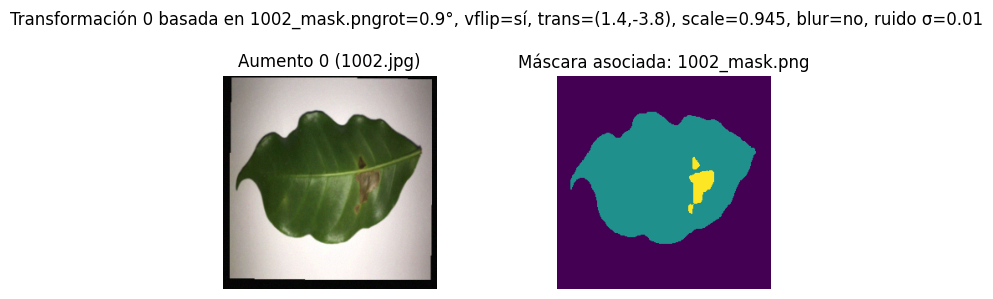

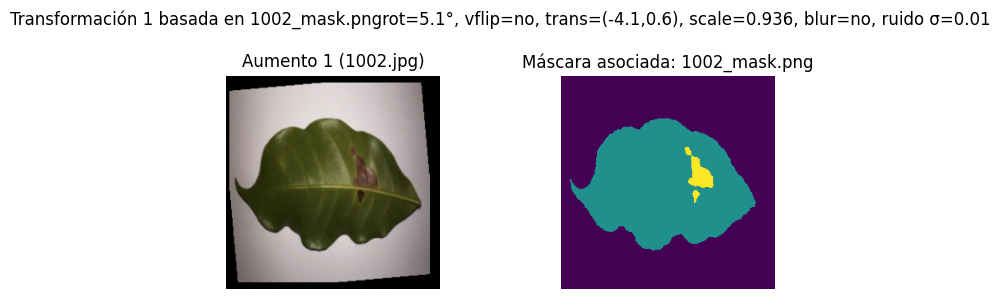

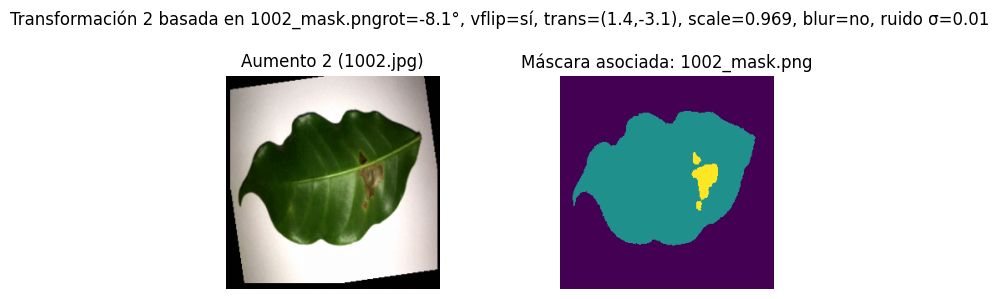

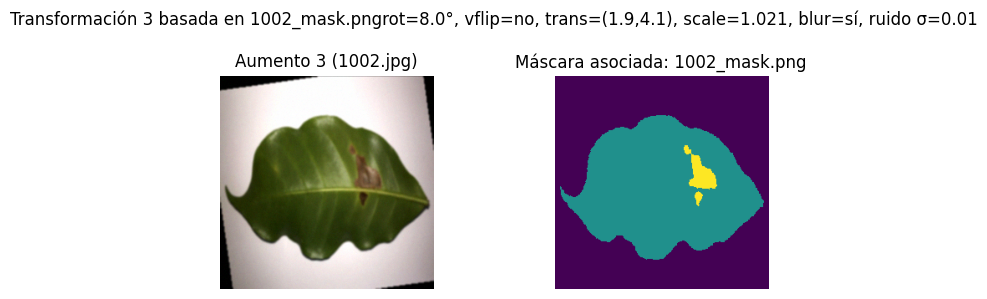

In [7]:
1002
sample_img_path = "coffee_leaves/coffee_leaves/train/imgs/1002.jpg"
sample_mask_path = "coffee_leaves/coffee_leaves/train/masks/1002_mask.png"

sample_img = Image.open(sample_img_path).convert("RGB")
sample_mask = Image.open(sample_mask_path)

img_name = os.path.basename(sample_img_path)
mask_name = os.path.basename(sample_mask_path)

for i in range(4):
    img_t, mask_t, metadata = preprocess_training_sample(
        sample_img.copy(), sample_mask.copy(), return_metadata=True
    )

    geom = (
        f"rot={metadata['rotation_deg']:.1f}°, vflip={'sí' if metadata['vertical_flip'] else 'no'}, "
        f"trans=({metadata['translate_px'][0]:.1f},{metadata['translate_px'][1]:.1f}), "
        f"scale={metadata['scale_factor']:.3f}"
    )
    blur_txt = 'sí' if metadata['blur_applied'] else 'no'

    fig, axes = plt.subplots(1, 2, figsize=(7, 3))
    axes[0].imshow(img_t.permute(1, 2, 0).cpu().numpy() * IMG_STD.numpy() + IMG_MEAN.numpy())
    axes[0].set_title(f"Aumento {i} ({img_name})")
    axes[0].axis('off')

    axes[1].imshow(mask_t.cpu().numpy(), vmin=0, vmax=2, cmap='viridis')
    axes[1].set_title(f"Máscara asociada: {mask_name}")
    axes[1].axis('off')

    fig.suptitle(f"Transformación {i} basada en {mask_name}"f"{geom}, blur={blur_txt}, ruido σ={metadata['noise_std']}"
    )
    plt.tight_layout()
    plt.show()



In [8]:
sample_mask_path = "coffee_leaves/coffee_leaves/train/masks/1002_mask.png"
mask_tensor = mask_to_tensor(Image.open(sample_mask_path))
print("Ruta de máscara:", sample_mask_path)
print("dtype:", mask_tensor.dtype)
print("Valores únicos:", mask_tensor.unique())


Ruta de máscara: coffee_leaves/coffee_leaves/train/masks/1002_mask.png
dtype: torch.int64
Valores únicos: tensor([0, 1, 2])


In [9]:

# Dataset y DataLoaders para train/val/test
class CoffeeLeavesDataset(Dataset):
    def __init__(self, root_dir, filenames=None, mode='train'):
        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, 'imgs')
        self.mask_dir = os.path.join(root_dir, 'masks')
        self.mode = mode

        all_imgs = sorted([
            f for f in os.listdir(self.img_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        if filenames is None:
            filenames = all_imgs
        self.filenames = filenames

        self.has_masks = os.path.isdir(self.mask_dir)
        if self.has_masks:
            mask_candidates = [
                os.path.join(self.mask_dir, os.path.splitext(name)[0] + '_mask.png')
                for name in self.filenames
            ]
            missing = [mp for mp in mask_candidates if not os.path.exists(mp)]
            if missing:
                raise FileNotFoundError(f"No se encontraron mascaras para: {missing[:3]}")

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert('RGB')

        if not self.has_masks:
            img = resize_transform(img)
            img = transforms.ToTensor()(img)
            img = normalize_transform(img)
            return img, img_path

        mask_name = os.path.splitext(img_name)[0] + '_mask.png'
        mask_path = os.path.join(self.mask_dir, mask_name)
        mask = Image.open(mask_path)

        if self.mode == 'train':
            img_t, mask_t = preprocess_training_sample(img, mask)
        else:
            img_t, mask_t = preprocess_validation_sample(img, mask)
        return img_t, mask_t

def build_dataloaders(train_root, test_root, val_fraction=0.15, batch_size=4, seed=42):
    rng = random.Random(seed)
    img_dir = os.path.join(train_root, 'imgs')
    all_files = sorted([
        f for f in os.listdir(img_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    rng.shuffle(all_files)
    val_count = max(1, int(len(all_files) * val_fraction))
    val_files = all_files[:val_count]
    train_files = all_files[val_count:]

    train_dataset = CoffeeLeavesDataset(train_root, filenames=train_files, mode='train')
    val_dataset = CoffeeLeavesDataset(train_root, filenames=val_files, mode='val')
    test_dataset = CoffeeLeavesDataset(test_root, mode='val')

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader

TRAIN_ROOT = os.path.join('coffee_leaves', 'coffee_leaves', 'train')
TEST_ROOT = os.path.join('coffee_leaves', 'coffee_leaves', 'test')

train_loader, val_loader, test_loader = build_dataloaders(
    TRAIN_ROOT,
    TEST_ROOT,
    val_fraction=0.15,
    batch_size=4,
)

print(f"Train samples: {len(train_loader.dataset)}")
print(f"Val samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")



Train samples: 340
Val samples: 60
Test samples: 100


In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        x = self.pool(x)
        return self.conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.reduce = nn.Conv2d(in_channels // 2, in_channels // 2, kernel_size=1)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.reduce = nn.Identity()
        self.conv = DoubleConv(in_channels, out_channels)
        self.bilinear = bilinear

    def forward(self, x1, x2):
        x1 = self.up(x1)
        if self.bilinear:
            x1 = self.reduce(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3, bilinear=True):
        super().__init__()
        self.in_conv = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)

def pixel_accuracy(preds, targets):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == targets).float().sum()
    total = torch.numel(targets)
    return (correct / total).item()

def compute_iou(preds, targets, num_classes=3, eps=1e-6):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_cls = preds == cls
        target_cls = targets == cls
        intersection = (pred_cls & target_cls).float().sum()
        union = (pred_cls | target_cls).float().sum()
        if union == 0:
            continue
        ious.append((intersection + eps) / (union + eps))
    if not ious:
        return 0.0
    return torch.stack(ious).mean().item()

def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [11]:

# Utilidades de entrenamiento + EarlyStopping
from collections import defaultdict

class EarlyStopping:
    def __init__(self, patience=4, min_delta=1e-3):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best = None
        self.should_stop = False
        self.best_state = None

    def step(self, metric, model):
        if self.best is None or metric < self.best - self.min_delta:
            self.best = metric
            self.counter = 0
            self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    total_batches = 0
    for imgs, masks in loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_batches += 1
    return total_loss / max(total_batches, 1)

@torch.no_grad()
def evaluate(model, loader, criterion, device, num_classes=3):
    model.eval()
    total_loss = 0.0
    total_batches = 0
    total_acc = 0.0
    total_iou = 0.0
    for imgs, masks in loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        logits = model(imgs)
        loss = criterion(logits, masks)
        total_loss += loss.item()
        total_batches += 1
        total_acc += pixel_accuracy(logits, masks)
        total_iou += compute_iou(logits, masks, num_classes=num_classes)
    avg_loss = total_loss / max(total_batches, 1)
    avg_acc = total_acc / max(total_batches, 1)
    avg_iou = total_iou / max(total_batches, 1)
    return avg_loss, avg_acc, avg_iou



In [13]:

# Búsqueda simple de hiperparámetros con EarlyStopping
import os

device = get_device()
print("Entrenando en:", device)

experiments = [
    {"name": "exp_lr1e-3", "lr": 1e-3, "weight_decay": 1e-4, "epochs": 20, "patience": 5},
    {"name": "exp_lr5e-4", "lr": 5e-4, "weight_decay": 1e-5, "epochs": 25, "patience": 6},
]

os.makedirs("checkpoints", exist_ok=True)
search_results = []

for cfg in experiments:
    print(f">>> Experimento {cfg['name']}")
    model = UNet(n_channels=3, n_classes=3).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    early = EarlyStopping(patience=cfg.get('patience', 5), min_delta=1e-3)

    history = []
    for epoch in range(1, cfg['epochs'] + 1):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_iou = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_loss)
        history.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_iou': val_iou,
        })
        print(f"Epoch {epoch:02d}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_iou={val_iou:.3f}")

        early.step(val_loss, model)
        if early.should_stop:
            print(f"Early stopping activado en epoch {epoch}")
            break

    best_state = early.best_state if early.best_state is not None else model.state_dict()
    checkpoint_path = os.path.join('checkpoints', f"{cfg['name']}_best.pt")
    torch.save(best_state, checkpoint_path)

    search_results.append({
        'config': cfg,
        'history': history,
        'best_val_loss': early.best if early.best is not None else history[-1]['val_loss'],
        'checkpoint': checkpoint_path,
    })

print("Resumen de experimentos:")
for res in search_results:
    print(f"{res['config']['name']}: best_val_loss={res['best_val_loss']:.4f}, checkpoint={res['checkpoint']}")



Entrenando en: cpu
>>> Experimento exp_lr1e-3
Epoch 01: train_loss=0.1814 | val_loss=0.0560 | val_iou=0.870


KeyboardInterrupt: 